In [2]:
import pandas as pd
import numpy as np
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

In [4]:
# Load datasets
train = pd.read_csv("./../datasets/train.csv", parse_dates=["Date"])
features = pd.read_csv("./../datasets/features.csv", parse_dates=["Date"])
stores = pd.read_csv("./../datasets/stores.csv")

# Merge datasets
df = train.merge(features, on=["Store","Date"], how="left")
df = df.merge(stores, on="Store", how="left")

print(df.head())

   Store  Dept       Date  Weekly_Sales  IsHoliday_x  Temperature  Fuel_Price  \
0      1     1 2010-02-05      24924.50        False        42.31       2.572   
1      1     1 2010-02-12      46039.49         True        38.51       2.548   
2      1     1 2010-02-19      41595.55        False        39.93       2.514   
3      1     1 2010-02-26      19403.54        False        46.63       2.561   
4      1     1 2010-03-05      21827.90        False        46.50       2.625   

   MarkDown1  MarkDown2  MarkDown3  MarkDown4  MarkDown5         CPI  \
0        NaN        NaN        NaN        NaN        NaN  211.096358   
1        NaN        NaN        NaN        NaN        NaN  211.242170   
2        NaN        NaN        NaN        NaN        NaN  211.289143   
3        NaN        NaN        NaN        NaN        NaN  211.319643   
4        NaN        NaN        NaN        NaN        NaN  211.350143   

   Unemployment  IsHoliday_y Type    Size  
0         8.106        False    A  1

In [5]:
df = df.sort_values(["Store","Dept","Date"])
df["Lag1"] = df.groupby(["Store","Dept"])["Weekly_Sales"].shift(1)
df["Lag4"] = df.groupby(["Store","Dept"])["Weekly_Sales"].shift(4)

In [6]:
df["MA4"] = df.groupby(["Store","Dept"])["Weekly_Sales"].shift(1).rolling(4).mean()

In [7]:
df["Week"] = df["Date"].dt.isocalendar().week.astype(int)
df["Month"] = df["Date"].dt.month
df["Year"] = df["Date"].dt.year

In [8]:
df = df.dropna()

In [9]:
# Features and target
X = df[["Store","Dept","Lag1","Lag4","MA4","Temperature","Fuel_Price","CPI","Unemployment","Week","Month","Year"]]
y = df["Weekly_Sales"]

# Split into train & test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

In [10]:
model = XGBRegressor(
    n_estimators=300,
    learning_rate=0.1,
    max_depth=8,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42
)

model.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.8, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             feature_weights=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.1, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=8,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=300,
             n_jobs=None, num_parallel_tree=None, ...)

In [12]:
y_pred = model.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print("XGBoost RMSE:", rmse)

XGBoost RMSE: 3454.792469851808


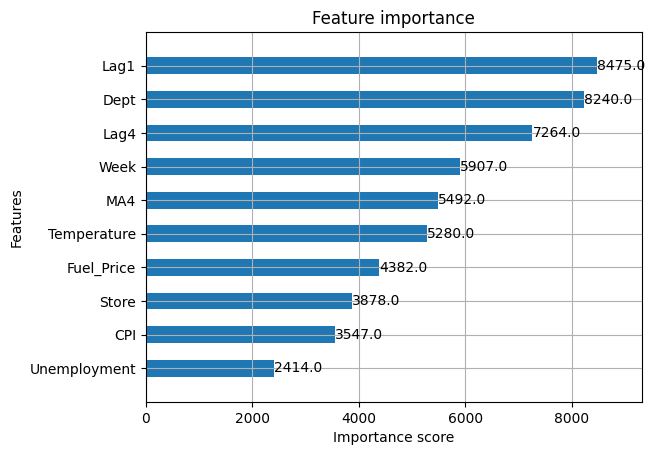

In [13]:
import matplotlib.pyplot as plt
import xgboost as xgb

xgb.plot_importance(model, max_num_features=10, height=0.5)
plt.show()

In [17]:
# Use same lag features as before
X = df[["Lag1","Lag4"]]
y = df["Weekly_Sales"]

model = XGBRegressor(n_estimators=300, learning_rate=0.1, max_depth=8, random_state=42)
model.fit(X, y)


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             feature_weights=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.1, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=8,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=300,
             n_jobs=None, num_parallel_tree=None, ...)

In [18]:
# Start from the last known row
future_preds = []
last_known = df.iloc[-4:]  # keep last 4 weeks for lagging

for i in range(12):  # forecast 12 future weeks
    # Get latest lags
    lag1 = last_known.iloc[-1]["Weekly_Sales"]
    lag4 = last_known.iloc[-4]["Weekly_Sales"]

    # Predict next week's sales
    next_pred = model.predict(np.array([[lag1, lag4]]))[0]
    future_preds.append(next_pred)

    # Append to last_known (simulate as if it was real data)
    new_row = last_known.iloc[-1].copy()
    new_row["Weekly_Sales"] = next_pred
    last_known = pd.concat([last_known, pd.DataFrame([new_row])], ignore_index=True)


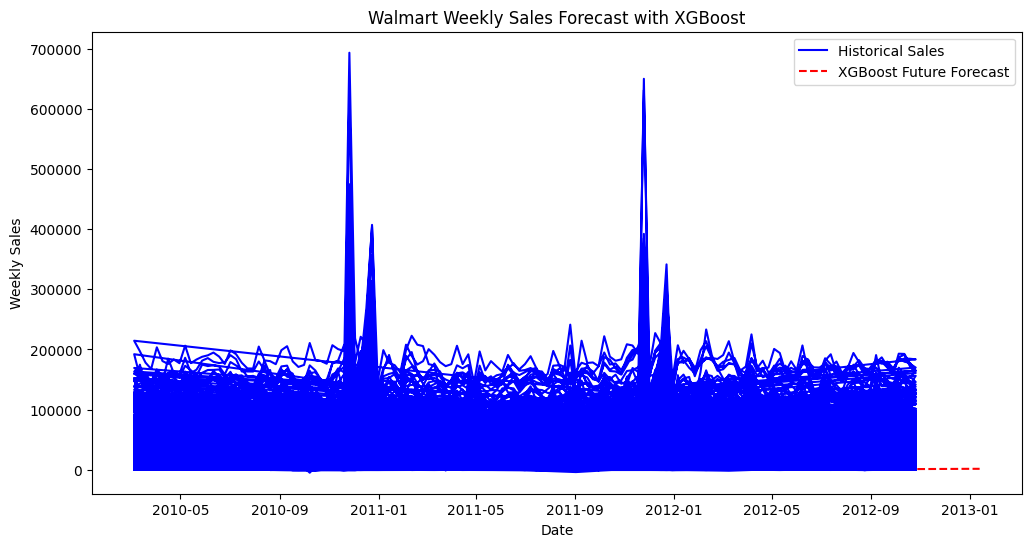

In [19]:
# Build future date index
last_date = df["Date"].max()
future_dates = pd.date_range(last_date, periods=12, freq="W")

plt.figure(figsize=(12,6))
plt.plot(df["Date"], df["Weekly_Sales"], label="Historical Sales", color="blue")
plt.plot(future_dates, future_preds, label="XGBoost Future Forecast", color="red", linestyle="dashed")
plt.xlabel("Date")
plt.ylabel("Weekly Sales")
plt.title("Walmart Weekly Sales Forecast with XGBoost")
plt.legend()
plt.show()
